In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import h5py
from matplotlib.colors import LogNorm
import multiprocessing as multi
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
import seaborn as sns
import sys
from tqdm import tqdm_notebook

d = "/Users/wfarr/Research/CBCPopulation/O2Populations/code"
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [3]:
BBHs = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170818', 'GW170823']

In [4]:
m1s = []
m2s = []
dls = []
for b in BBHs:
    with h5py.File('./GWTC-1/GWTC-1_sample_release/'+b+'_GWTC-1.hdf5', 'r') as f:
        m1s.append(array(f['Overall_posterior']['m1_detector_frame_Msun']))
        m2s.append(array(f['Overall_posterior']['m2_detector_frame_Msun']))
        dls.append(array(f['Overall_posterior']['luminosity_distance_Mpc']))
        
wts = []
for d in dls:
    wts.append(1.0/(d*d))

In [5]:
m1s_re = []
m2s_re = []
dls_re = []
for m1, m2, dl, wt in zip(m1s, m2s, dls, wts):
    wmax = np.max(wt)
    rs = random.uniform(low=0, high=wmax, size=len(m1))
    sel = rs < wt
    
    m1s_re.append(m1[sel])
    m2s_re.append(m2[sel])
    dls_re.append(dl[sel])
lmin = np.min([len(x) for x in m1s_re])

In [6]:
m1s_out = []
m2s_out = []
dls_out = []
for m1, m2, dl in zip(m1s_re, m2s_re, dls_re):
    p = random.choice(len(m1), size=lmin, replace=False)
    m1s_out.append(m1[p])
    m2s_out.append(m2[p])
    dls_out.append(dl[p])
m1s_out = array(m1s_out)
m2s_out = array(m2s_out)
dls_out = array(dls_out)

Text(0, 0.5, '$p(z)$')

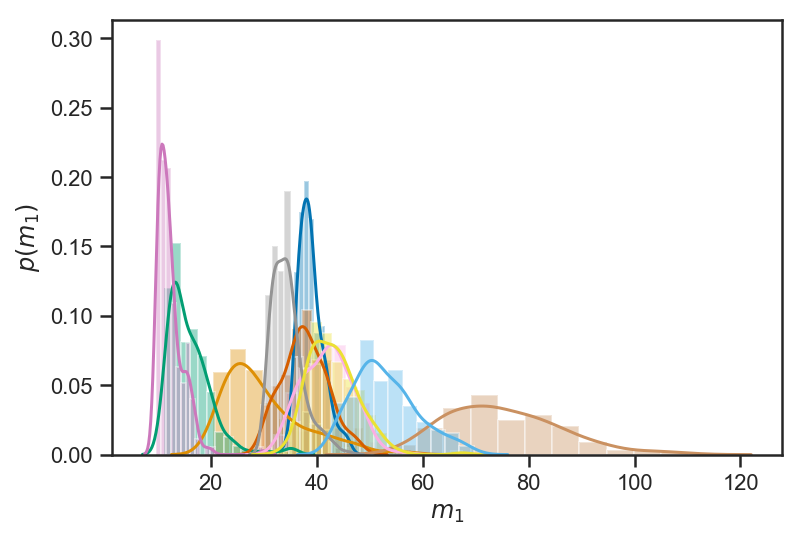

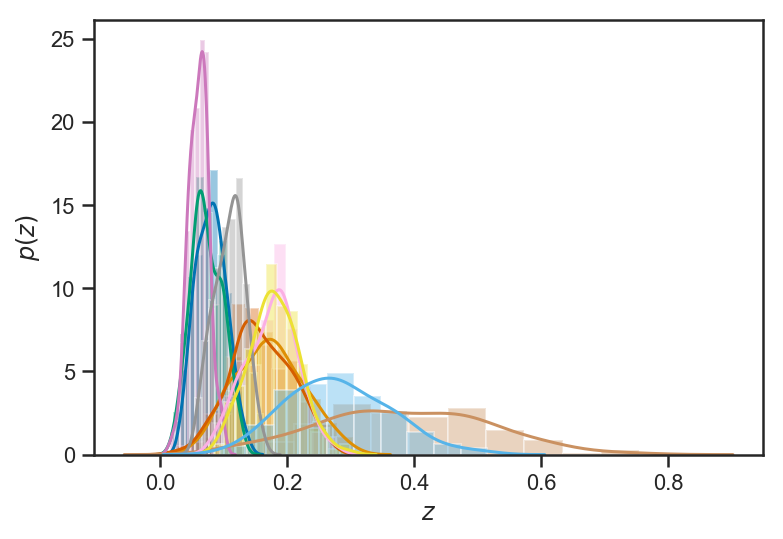

In [7]:
for m1 in m1s_out:
    sns.distplot(m1)
xlabel(r'$m_1$')
ylabel(r'$p\left( m_1 \right)$')

z = linspace(0, 2, 1000)
d = Planck15.luminosity_distance(z).to(u.Mpc).value
z_of_d = interp1d(d, z)

figure()
for dl in dls_out:
    sns.distplot(z_of_d(dl))
xlabel(r'$z$')
ylabel(r'$p(z)$')

In [8]:
with h5py.File('GWTC-1/GWTC-1-observations.h5', 'w') as f:
    g = f.create_group('posteriors')
    g.create_dataset('m1det', data=m1s_out, compression='gzip', shuffle=True)
    g.create_dataset('m2det', data=m2s_out, compression='gzip', shuffle=True)
    g.create_dataset('dl', data=dls_out/1000, compression='gzip', shuffle=True)

    f.attrs['Tobs'] = (51.5+118.0)/365.25

Now we make the "injection" set that we need to estimate VT for this population.  We do this by drawing from a broad distribution that is meant to represent the true population (or at least to be close to it).

In [9]:
MMin = 3
MMax = 120
zmax = 0.8

def draw_m1():
    return exp(log(MMin) + log(MMax/MMin)*rand())
def pm1(m1):
    return 1.0/(m1*log(MMax/MMin))

def draw_m2(m1):
    return MMin + (m1-MMin)*rand()
def pm2(m1, m2):
    return 1.0/(m1-MMin)

def draw_z():
    return expm1(log(1) + log((1+zmax)/1)*rand())
def pdl(z):
    return 1/(1+z)/log1p(zmax)

In [10]:
ms = exp(linspace(log(1), log(120), 100))
M1S, M2S = meshgrid(ms, ms, indexing='ij')

z1 = cosmo.z_at_value(Planck15.luminosity_distance, 1*u.Gpc)

def osm1m2(m1m2):
    m1, m2 = m1m2
    
    m1s = m1/(1+z1)
    m2s = m2/(1+z1)
    
    return vt.optimal_snr(m1s, m2s, z1, psd_fn=vt.ls.SimNoisePSDaLIGOEarlyHighSensitivityP1200087)

pool = multi.Pool()
try:
    OSNRS = list(tqdm_notebook(pool.imap(osm1m2, zip(M1S.ravel(), M2S.ravel())), total=len(M1S.ravel())))
    OSNRS = array(OSNRS).reshape(M1S.shape)
finally:
    pool.close()

oss = RectBivariateSpline(ms, ms, OSNRS)

def optimal_snr(m1, m2, z):
    m1d = m1*(1+z)
    m2d = m2*(1+z)
    
    d = Planck15.luminosity_distance(z).to(u.Gpc).value
    
    return oss.ev(m1d, m2d)/d

In [11]:
vt.optimal_snr(35.0, 40.0, 0.53, psd_fn=vt.ls.SimNoisePSDaLIGOEarlyHighSensitivityP1200087), optimal_snr(35.0, 40.0, 0.53)

(8.359287193736202, 8.359287994132776)

In [12]:
Ngen = 0
Ninj_det = 32768
snr_thresh = 8

m1sel = []
m2sel = []
dlsel = []
wtsel = []

with tqdm_notebook(total=Ninj_det) as bar:
    while len(m1sel) < Ninj_det:
        m1 = draw_m1()
        m2 = draw_m2(m1)
        z = draw_z()
        dl = Planck15.luminosity_distance(z).to(u.Gpc).value
        wt = pm1(m1)*pm2(m1,m2)*pdl(z)
        
        m1 = float(m1)
        m2 = float(m2)
        dl = float(dl)
        wt = float(wt)
        z = float(z)
        
        os = optimal_snr(m1/(1+z), m2/(1+z), z)
        s = random.choice(vt.thetas)*os + randn()
        
        if s > snr_thresh:
            m1sel.append(m1)
            m2sel.append(m2)
            dlsel.append(dl)
            wtsel.append(wt)
            
            bar.update(1)
        
        Ngen += 1

In [13]:
with h5py.File('GWTC-1/GWTC-1-selected.h5', 'w') as f:
    f.attrs['N_gen'] = Ngen
    f.create_dataset('m1det', data=m1sel, compression='gzip', shuffle=True)
    f.create_dataset('m2det', data=m2sel, compression='gzip', shuffle=True)
    f.create_dataset('dl', data=dlsel, compression='gzip', shuffle=True)
    f.create_dataset('wt', data=wtsel, compression='gzip', shuffle=True)

In [14]:
print('Number generated = {:d}'.format(Ngen))

Number generated = 220567


Now let's check how many GMM components we need for this population.

In [18]:
ngs = []
scores = []
for ng in tqdm_notebook(range(1, 7)):
    gmm = GaussianMixture(ng)
    s = []
    for m1, m2, dl in zip(m1s_out, m2s_out, dls_out/1000):
        N = m1.shape[0]
        p = random.permutation(N)
        N2 = N//2
        
        train_pts = column_stack((m1[p][:N2], m2[p][:N2], dl[p][:N2]))
        test_pts = column_stack((m1[p][N2:], m2[p][N2:], dl[p][N2:]))
        
        gmm.fit(train_pts)
        
        s.append(gmm.score(test_pts))
    scores.append(s)
    ngs.append(ng)
scores = array(scores)
ngs = array(ngs)

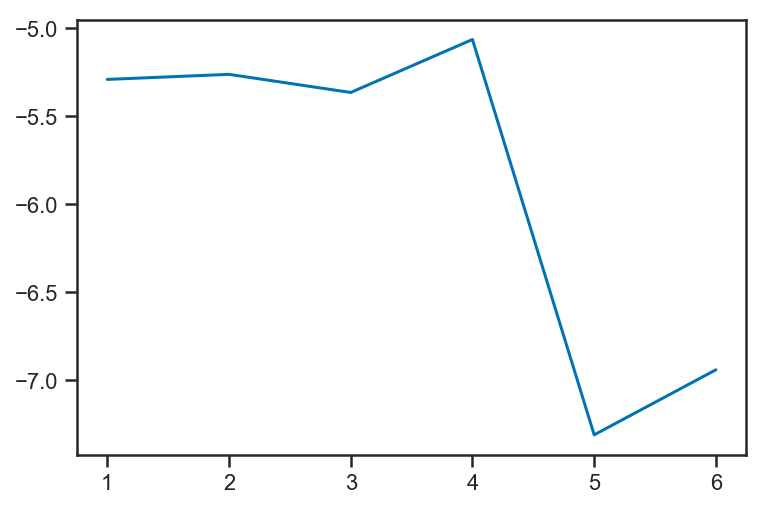

In [19]:
plot(ngs, mean(scores, axis=1))

In [20]:
ngs[argmax(mean(scores, axis=1))]

4